### Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256 entries, 0 to 12255
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             12256 non-null  float64
 1   bath            12256 non-null  float64
 2   acre_lot        12256 non-null  float64
 3   zip_code        12256 non-null  float64
 4   house_size      12256 non-null  float64
 5   prev_sold_date  12256 non-null  object 
 6   price           12256 non-null  float64
dtypes: float64(6), object(1)
memory usage: 670.4+ KB


#### Create new feature prev_sold_year from prev_sold_date

In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256 entries, 0 to 12255
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             12256 non-null  float64
 1   bath            12256 non-null  float64
 2   acre_lot        12256 non-null  float64
 3   zip_code        12256 non-null  float64
 4   house_size      12256 non-null  float64
 5   price           12256 non-null  float64
 6   prev_sold_year  12256 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 670.4 KB


#### Create a new feature in the housing data for Zip Code with a leading zero

#### Create a new feature in the Lat/Long data for Zip Code with a leading zero

In [5]:
zip_lon_lat = pd.read_csv('ny_zip-lon-lat.csv')
zip_lon_lat.head()

,zip_code,latitude,longitude
0,10001,40.750633,-73.997177
1,10002,40.715775,-73.986212
2,10003,40.731829,-73.989181
3,10004,40.688630,-74.018244
4,10005,40.706027,-74.008835


#### Merge the Lat/Long data with the housing data using Zip Code with a leading zero

In [6]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how='inner', on="zip_code")
merged_df.tail()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,latitude,longitude
12237,3.0,2.0,0.19,14219.0,1506.0,189900.0,2019,42.788675,-78.826431
12238,2.0,2.0,0.20,14219.0,1259.0,224900.0,2018,42.788675,-78.826431
12239,4.0,2.0,0.17,14219.0,1884.0,175000.0,2016,42.788675,-78.826431
12240,4.0,3.0,0.41,14219.0,2664.0,289000.0,2018,42.788675,-78.826431
12241,3.0,2.0,0.34,14219.0,1350.0,194900.0,2020,42.788675,-78.826431


#### Create common variables to store frequently used values.

In [7]:
features = ["latitude","longitude","bed","bath","acre_lot","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [8]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [9]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [10]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
        
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

#### Create common variables that will be used in the Notebook

In [11]:
ridge = Ridge(random_state=42)
ridge_sfs = SequentialFeatureSelector(estimator=ridge, n_features_to_select=num_features_to_select)
ridge_sfm = SelectFromModel(estimator=ridge, threshold=1000)
ridge_rfe = RFE(estimator=ridge, n_features_to_select=num_features_to_select)

#### Use Grid Search CV to find the best Hyperparameters for R9dge Regression

In [12]:
ridge_gscv = GridSearchCV(Ridge(random_state=42), {'alpha': np.arange(1.0,1.5,0.01)})
ridge_gscv_model = ridge_gscv.fit(X, y)
print(f"Best parameters found: {ridge_gscv.best_params_}")

Best parameters found: {'alpha': 1.4900000000000004}


In [13]:
ridge = Ridge(**ridge_gscv.best_params_)
ridge_bp_gscv = GridSearchCV(ridge, param_grid={})
ridge_bp_model = ridge_bp_gscv.fit(X_train,y_train)
ridge_bp_predict = ridge_bp_model.predict(X_test)

print_more_stuff("Ridge Best Params", y_test, ridge_bp_predict, ridge_bp_gscv)

Ridge Best Params EVS = 0.296428194
Ridge Best Params MSE = 548,771,706,969.938110
Ridge Best Params MAE = 440,863.339725
Ridge Best Params R2 = 0.296282
Ridge Best Params Fit Time = 0.0016129493713378906


### SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.

In [14]:
ridge_sfm_pipeline = Pipeline([
  ('feature_selection', ridge_sfm),
  ('regression', ridge)
])

ridge_sfm_fs = ridge_sfm_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_sfm_selected_features = ridge_sfm_fs.get_support()

print('The selected features are:', list(X.columns[ridge_sfm_selected_features]))

The selected features are: ['latitude', 'bed', 'bath', 'prev_sold_year']


In [15]:
X_sfm = merged_df[list(X.columns[ridge_sfm_selected_features])]
y_sfm = merged_df["price"]
X_sfm_train, X_sfm_test, y_sfm_train, y_sfm_test = train_test_split(X_sfm, y_sfm, test_size=0.3, random_state=random_state_value)

In [16]:
ridge_sfm_gscv = GridSearchCV(Ridge(), param_grid={})
ridge_sfm_model = ridge_sfm_gscv.fit(X_sfm_train,y_sfm_train)
ridge_sfm_predict = ridge_sfm_model.predict(X_sfm_test)

print_more_stuff("Select From Model",y_sfm_test,ridge_sfm_predict,ridge_sfm_gscv)

Select From Model EVS = 0.279605820
Select From Model MSE = 561,904,158,591.280029
Select From Model MAE = 441,349.215152
Select From Model R2 = 0.279442
Select From Model Fit Time = 0.0


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [17]:
ridge_sfs_pipeline = Pipeline([
  ('feature_selection', ridge_sfs),
  ('regression', ridge)
])

ridge_sfs_fs = ridge_sfs_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_sfs_selected_features = ridge_sfs_fs.get_support()

print('The selected features are:', list(X.columns[ridge_sfs_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size', 'prev_sold_year']


In [18]:
X_sfs = merged_df[list(X.columns[ridge_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [19]:
ridge_sfs_gscv = GridSearchCV(Ridge(), param_grid={})
ridge_sfs_model = ridge_sfs_gscv.fit(X_sfs_train,y_sfs_train)
ridge_sfs_predict = ridge_sfs_model.predict(X_sfs_test)

print_more_stuff("Sequential Feature Selector",y_sfs_test,ridge_sfs_predict,ridge_sfs_gscv)

Sequential Feature Selector EVS = 0.296057989
Sequential Feature Selector MSE = 549,063,929,595.034119
Sequential Feature Selector MAE = 440,806.949119
Sequential Feature Selector R2 = 0.295908
Sequential Feature Selector Fit Time = 0.0


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [20]:
ridge_rfe_pipeline = Pipeline([
  ('feature_selection', ridge_rfe),
  ('regression', ridge)
])
ridge_rfe_fs = ridge_rfe_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_rfe_selected_features = ridge_rfe_fs.get_support()

print('The selected features are:', list(X.columns[ridge_rfe_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size', 'prev_sold_year']


In [21]:
X_rfe = merged_df[list(X.columns[ridge_rfe_selected_features])]
y_rfe = merged_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [22]:
ridge_rfe_gscv = GridSearchCV(Ridge(), param_grid={})
ridge_rfe_model = ridge_rfe_gscv.fit(X_rfe_train,y_rfe_train)
ridge_rfe_predict = ridge_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination",y_rfe_test,ridge_rfe_predict, ridge_rfe_gscv)

Recursive Feature Elimination EVS = 0.296057989
Recursive Feature Elimination MSE = 549,063,929,595.034119
Recursive Feature Elimination MAE = 440,806.949119
Recursive Feature Elimination R2 = 0.295908
Recursive Feature Elimination Fit Time = 0.0032087326049804687


#### Graphing the results works best when the data is provided in a DataFrame.

In [23]:
ridge_bp_predict_df = pd.DataFrame(ridge_bp_predict).reset_index()
ridge_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_sfm_predict_df = pd.DataFrame(ridge_sfm_predict).reset_index()
ridge_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_sfs_predict_df = pd.DataFrame(ridge_sfs_predict).reset_index()
ridge_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_rfe_predict_df = pd.DataFrame(ridge_rfe_predict).reset_index()
ridge_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, Select From Model, and Test Data.

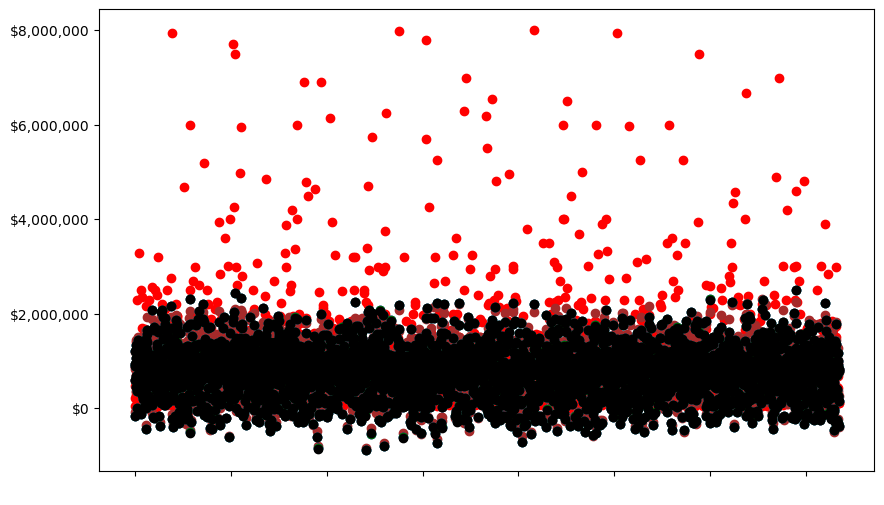

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(ridge_sfm_predict_df.index,ridge_sfm_predict_df["prediction"], color="brown")
plt.scatter(ridge_sfs_predict_df.index,ridge_sfs_predict_df["prediction"], color="blue")
plt.scatter(ridge_rfe_predict_df.index,ridge_rfe_predict_df["prediction"], color="green")
plt.scatter(ridge_bp_predict_df.index,ridge_bp_predict_df["prediction"], color="black")
plt.show()

#### Sort the DataFrames by the Prediction and Price features.

In [25]:
ridge_bp_predict_df.sort_values(by='prediction', inplace=True)
ridge_bp_predict_df.reset_index(inplace=True)

ridge_sfm_predict_df.sort_values(by='prediction', inplace=True)
ridge_sfm_predict_df.reset_index(inplace=True)

ridge_sfs_predict_df.sort_values(by='prediction', inplace=True)
ridge_sfs_predict_df.reset_index(inplace=True)

ridge_rfe_predict_df.sort_values(by='prediction', inplace=True)
ridge_rfe_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

#### Line graph of the results of Recursive Feature Elimination, Sequential Feature Selection, Select From Model, and Test Data.

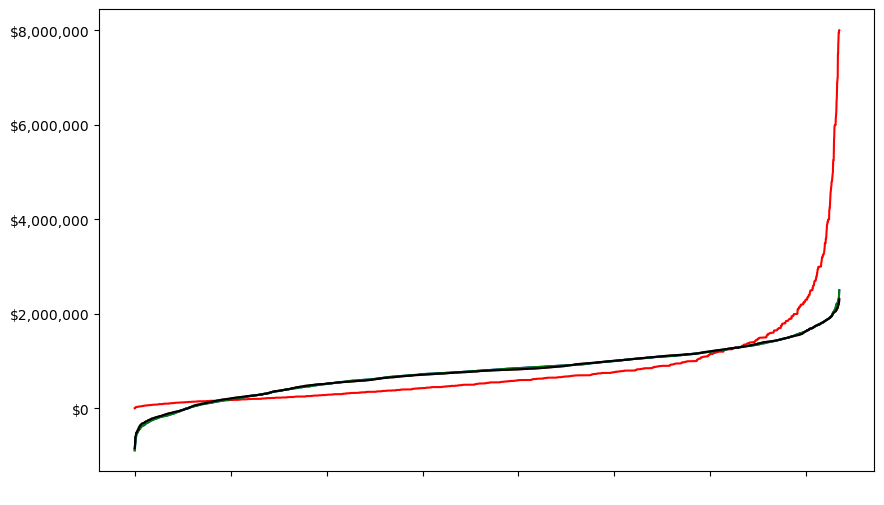

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')


plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(ridge_sfm_predict_df.index,ridge_sfm_predict_df["prediction"], color="brown")
plt.plot(ridge_sfs_predict_df.index,ridge_sfs_predict_df["prediction"], color="blue")
plt.plot(ridge_rfe_predict_df.index,ridge_rfe_predict_df["prediction"], color="green")
plt.plot(ridge_sfm_predict_df.index,ridge_sfm_predict_df["prediction"], color="black")
plt.show()

In [27]:
results_dict

{'model': ['Ridge Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination'],
 'explained variance score': ['0.296428194',
  '0.279605820',
  '0.296057989',
  '0.296057989'],
 'mae score': ['440,863.339725',
  '441,349.215152',
  '440,806.949119',
  '440,806.949119'],
 'mse score': ['548,771,706,969.938110',
  '561,904,158,591.280029',
  '549,063,929,595.034119',
  '549,063,929,595.034119'],
 'r2 score': ['0.296282', '0.279442', '0.295908', '0.295908'],
 'mean fit time': [0.0016129493713378906, 0.0, 0.0, 0.0032087326049804687]}

In [28]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Ridge Best Params,0.296428194,"440,863.339725","548,771,706,969.938110",0.296282,0.001613
Select From Model,0.279605820,"441,349.215152","561,904,158,591.280029",0.279442,0.000000
Sequential Feature Selector,0.296057989,"440,806.949119","549,063,929,595.034119",0.295908,0.000000
Recursive Feature Elimination,0.296057989,"440,806.949119","549,063,929,595.034119",0.295908,0.003209
